### Preprocessing round aperature few-tilt precession data

Example for data acquired with round aperature. Uses padding instead of just rolling for re-centering diffraction data.



---

''Multi-angle precession electron diffraction (MAPED): a versatile approach to 4D-STEM precession''

Stephanie M. Ribet [1], Rohan Dhall [1], Colin Ophus [2], Karen C. Bustillo [1]

[1] National Center for Electron Microscopy, Molecular Foundry, Lawrence Berkeley National Laboratory

[2] Department of Materials Science and Engineering, Stanford University


In [1]:
import numpy as np
import py4DSTEM
from emdfile import tqdmnd
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation

cupyx.jit.rawkernel is experimental. The interface can change in the future.


### define file paths

In [2]:
data_path = ''
file_path_0 = data_path + 'al_36_master.h5' #tilt 0
file_path_1 = data_path + 'al_37_master.h5' #tilt 1
file_path_2 = data_path + 'al_38_master.h5' #tilt 2
file_path_3 = data_path + 'al_39_master.h5' #tilt 3
file_path_4 = data_path + 'al_40_master.h5' #tilt 4

### center datasets in reciprocal space

In [4]:
def load_and_center_datacube(
    file_path,
    pad = False,
    bin_factor_R = 1,
    bin_factor_Q = 1
):
    """
    Function for loading and centering 4D-STEM datasets

    Parameters
    ----------
    file_path: str
        location of dataset to import
    pad: bool
        If True, pads before shiting diffraction data
    bin_factor_R: int
        binning factor in real space
    bin_factor_Q: int
        binning factor in reciprocal space

    Returns
    -------
    py4DTEM DataCube with 4D-STEM data diffraction space centered
    """
    dc1 = py4DSTEM.import_file(file_path).bin_R(bin_factor_R).bin_Q(bin_factor_Q) #change import_file to load_file if already a py4DSTEM datacube

    # method to find origin based on brightest peak
    (qx0, qy0, _) = py4DSTEM.process.calibration.get_origin(
        dc1,
        # r = 2.0,
        rscale = 1.2,
    )

    # remove NaNs from any bad pixels
    qx0[np.isnan(qx0)] = np.mean(qx0[~np.isnan(qx0)])
    qy0[np.isnan(qy0)] = np.mean(qy0[~np.isnan(qy0)])

    #fit measured shifts to a plane
    (qx0_fit, qy0_fit, qx0_res, qy0_res) = py4DSTEM.process.calibration.fit_origin(
        (qx0, qy0),
    )

    #pad data it necessary
    if pad == True: 
        shifts_x = dc1.Qshape[0]/2 - qx0_fit
        shifts_y = dc1.Qshape[1]/2 - qy0_fit
        pad_width = int(np.max((np.abs(shifts_x), np.abs(shifts_y))))
        dc1.data = np.pad(dc1.data, ((0,0), (0,0), (pad_width, pad_width), (pad_width, pad_width)))

    else: 
        pad_width = 0

    #center data with bilinear interpolation
    dc1.data = np.asarray(dc1.data, dtype = "float")
    for a0, a1 in tqdmnd(
        dc1.Rshape[0],
        dc1.Rshape[1],
        desc="aligning",
        unit="DP",
        unit_scale=True,
    ):
        dc1.data[a0,a1] = py4DSTEM.process.utils.get_shifted_ar(
            dc1.data[a0,a1],
            xshift=(dc1.Qshape[0]/2 - qx0_fit[a0,a1]-pad_width),
            yshift=(dc1.Qshape[1]/2 - qy0_fit[a0,a1]-pad_width),
            bilinear=True
        )
    return dc1

In [24]:
# load and center all datasets
dc0 = load_and_center_datacube(file_path_0,bin_factor_R = 2,bin_factor_Q = 2, pad = True)
dc1 = load_and_center_datacube(file_path_1,bin_factor_R = 2,bin_factor_Q = 2, pad = True)
dc2 = load_and_center_datacube(file_path_2,bin_factor_R = 2,bin_factor_Q = 2, pad = True)
dc3 = load_and_center_datacube(file_path_3,bin_factor_R = 2,bin_factor_Q = 2, pad = True)
dc4 = load_and_center_datacube(file_path_4,bin_factor_R = 2,bin_factor_Q = 2, pad = True)


Dataset is uint32 but will be converted to uint16


Finding origins: 100%|████████████████████| 65.5k/65.5k [00:18<00:00, 3.51kDP/s]
aligning: 100%|███████████████████████████| 65.5k/65.5k [00:05<00:00, 11.7kDP/s]


### find real space center of datasets 

100%|██████████████████████████████████| 65536/65536 [00:00<00:00, 77619.09it/s]


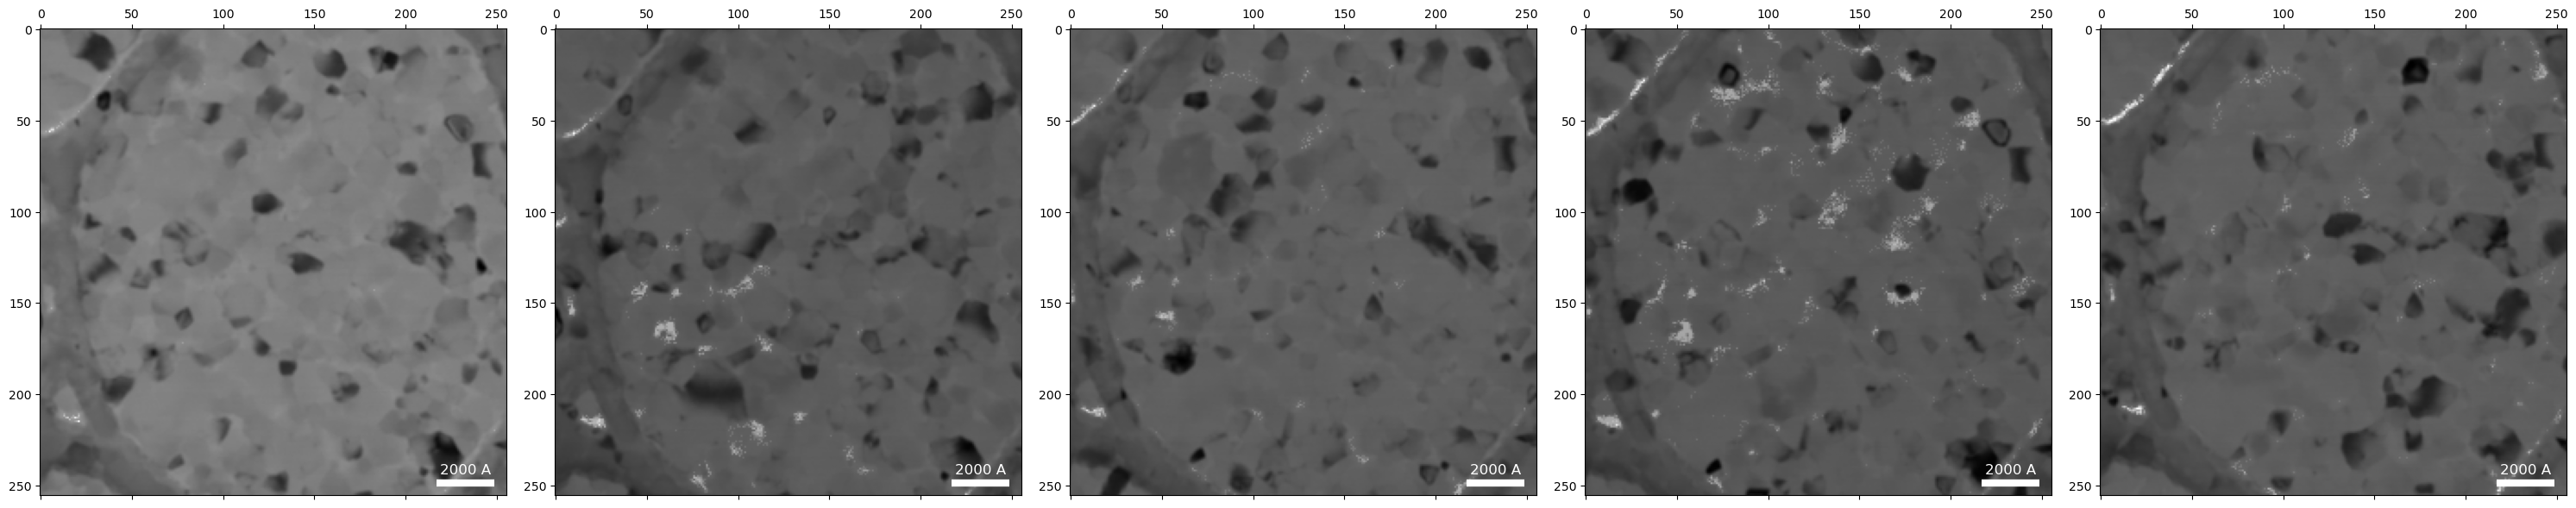

In [25]:
# make virtual dark-field images from each dataset
probe_semiangle = 4
geometry = ((dc0.Qshape[0]/2, dc0.Qshape[1]/2 ), probe_semiangle+5)
mode = "circular"
name = "DF"

dc0.get_virtual_image(
    geometry = geometry,
    mode = mode,
    name = name 
)

dc1.get_virtual_image(
    geometry = geometry,
    mode = mode,
    name = name 
    
)
dc2.get_virtual_image(
    geometry = geometry,
    mode = mode,
    name = name 
    
)
dc3.get_virtual_image(
    geometry = geometry,
    mode = mode,
    name = name 
    
)
dc4.get_virtual_image(
    geometry = geometry,
    mode = mode,
    name = name 
    
)

py4DSTEM.show(
    [
        dc0.tree('DF'),
        dc1.tree('DF'),
        dc2.tree('DF'),
        dc3.tree('DF'),
        dc4.tree('DF'),
        
    ],
    vmax =1,
    vmin = 0
    
)

In [26]:
# get mean diffraction pattern from each dataset

dc0.get_dp_mean()
dc1.get_dp_mean()
dc2.get_dp_mean()
dc3.get_dp_mean()
dc4.get_dp_mean()

VirtualDiffraction( A 2-dimensional array of shape (100, 100) called 'dp_mean',
                    with dimensions:

                        dim0 = [0,1,2,...] pixels
                        dim1 = [0,1,2,...] pixels
)

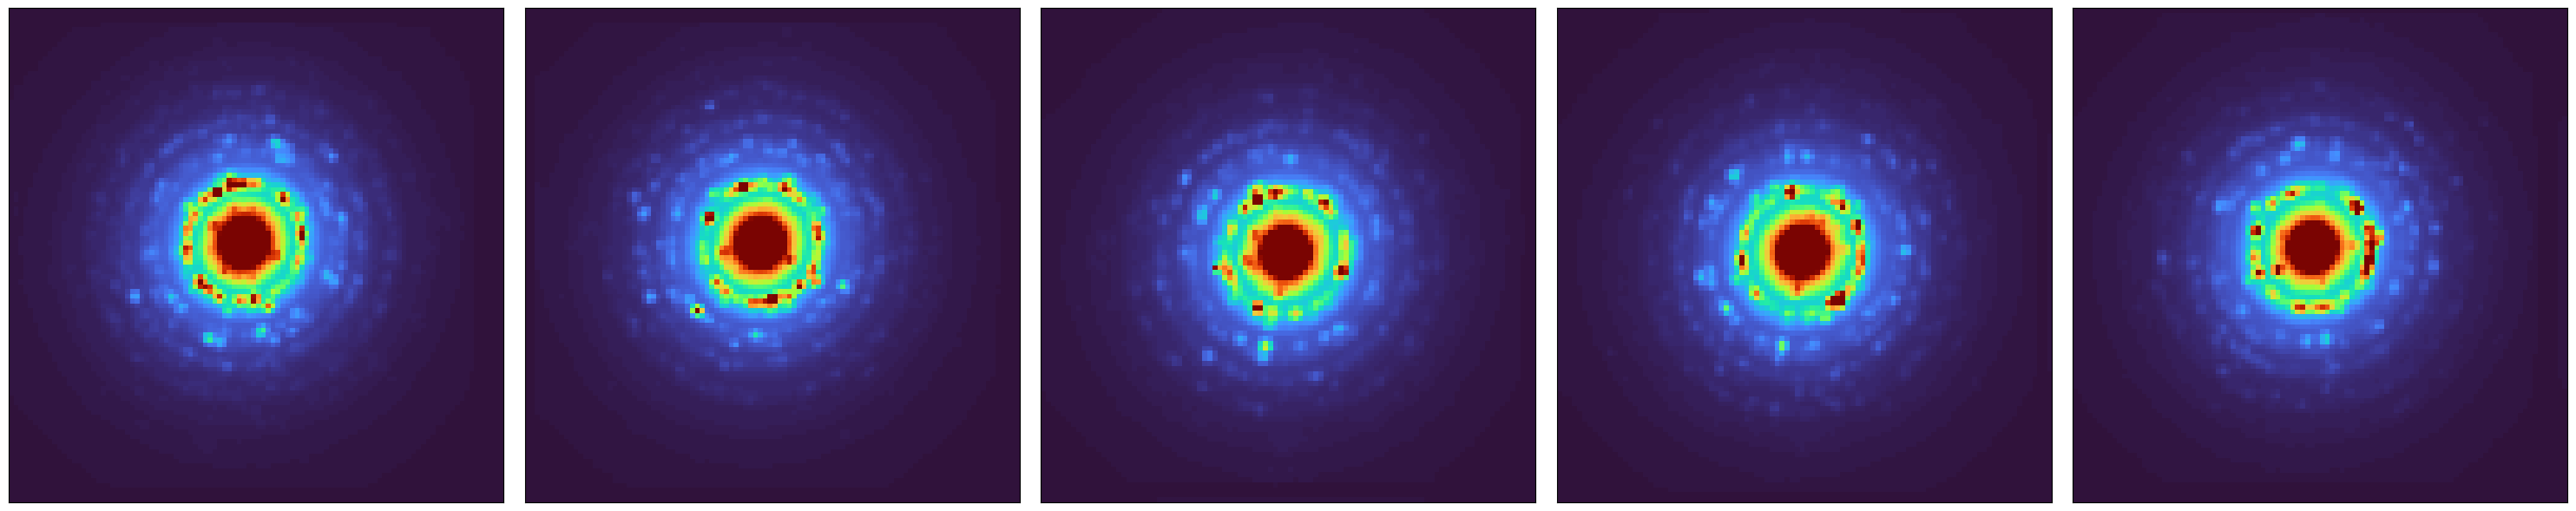

In [27]:
# show mean diffraction patterns from each dataset
fig, ax = py4DSTEM.show(
    [
        dc0.tree('dp_mean'),
        dc2.tree('dp_mean'),
        dc3.tree('dp_mean'),
        dc1.tree('dp_mean'),
        dc4.tree('dp_mean')
        
    ],
    ticks = False,
    scalebar = False,
    returnfig=True,
    vmax = 0.99,
    cmap  = "turbo"
)

plt.tight_layout()


In [28]:
# use cross-correlation to align bright field images.

shifts = np.zeros((5,2))

# mask can be used to make more robust fits 
mask = np.zeros((256,256))
mask[0:150] = 1

shifts[1] = phase_cross_correlation(
    dc0.tree('DF').data,
    dc1.tree('DF').data,
    # reference_mask = mask
)[0]

shifts[2] =  phase_cross_correlation(
    dc0.tree('DF').data,
    dc2.tree('DF').data,
    reference_mask = mask
)[0]


shifts[3] =  phase_cross_correlation(
    dc0.tree('DF').data,
    dc3.tree('DF').data,
    reference_mask = mask
)[0]

shifts[4] =  phase_cross_correlation(
    dc0.tree('DF').data,
    dc4.tree('DF').data,
    reference_mask = mask
)[0]


shifts = np.asarray(shifts, dtype = "int")

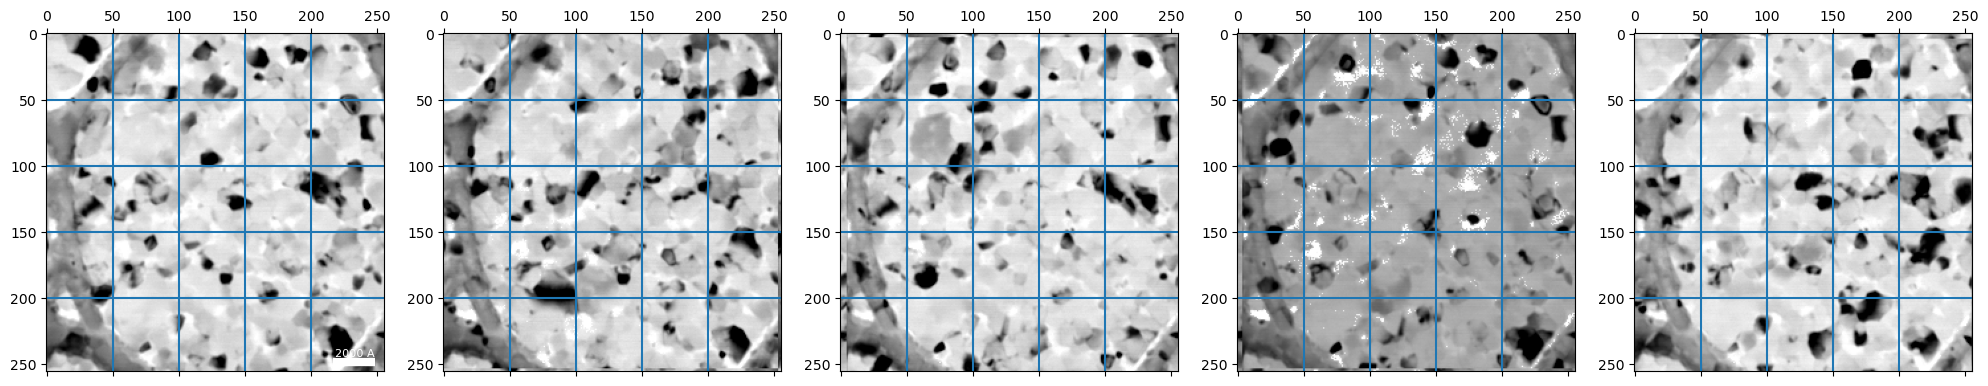

In [29]:
# show shifted dark-field images with overlaid grid to check alignment 

fig, ax= py4DSTEM.show(
    [
        dc0.tree('DF'),
        np.roll(dc1.tree('DF').data,shift=shifts[1], axis=(0,1)),
        np.roll(dc2.tree('DF').data,shift=shifts[2], axis=(0,1)),
        np.roll(dc3.tree('DF').data,shift=shifts[3], axis=(0,1)),
        np.roll(dc4.tree('DF').data,shift=shifts[4], axis=(0,1)),
    ],
    returnfig=True,
    axsize = (4,4),
    
)

for axs in ax.flatten(): 
    axs.axhline(50, 0,100,)
    axs.axhline(100, 0,100,)
    axs.axhline(150, 0,100,)
    axs.axhline(200, 0,100,)

    axs.axvline(50, 0,100,)
    axs.axvline(100, 0,100,)
    axs.axvline(150, 0,100,)
    axs.axvline(200, 0,100,)

### check dataset size in case pad==True

In [30]:
# calculate cropping range to find area where all scans overlap
crop_x_min = np.min(shifts[:,0])
crop_x_max = np.max(shifts[:,0])
crop_x_range = crop_x_max -crop_x_min

crop_y_min = np.min(shifts[:,1])
crop_y_max = np.max(shifts[:,1])
crop_y_range = crop_y_max -crop_y_min


In [31]:
print(crop_x_min, crop_x_max, crop_y_min, crop_y_max)

-2 5 -3 5


In [32]:
print((
    dc0.Qshape,
    dc1.Qshape,
    dc2.Qshape,
    dc3.Qshape,
    dc4.Qshape
))

((102, 102), (98, 98), (102, 102), (98, 98), (100, 100))


In [33]:
## if padded is True, need to reshape, find extra padding
max_qx = np.max((dc0.Qshape[0], dc1.Qshape[0], dc2.Qshape[0], dc3.Qshape[0], dc4.Qshape[0], ))
max_qy = np.max((dc0.Qshape[0], dc1.Qshape[0], dc2.Qshape[0], dc3.Qshape[0], dc4.Qshape[0], ))


In [34]:
#reshape
datacubes = [dc0, dc1, dc2, dc3, dc4]

for a0 in range(5): 
    
    if datacubes[a0].Qshape[0] != max_qx: 
        pad_extra = (max_qx - datacubes[a0].Qshape[0])//2
        datacubes[a0].data = np.pad(
            datacubes[a0].data,
            ((0,0),(0,0),(pad_extra, pad_extra), (0,0))
        )
    if datacubes[a0].Qshape[1] != max_qx: 
        pad_extra = (max_qy - datacubes[a0].Qshape[1])//2
        datacubes[a0].data = np.pad(
            datacubes[a0].data,
            ((0,0),(0,0),(0,0),(pad_extra, pad_extra))
        )

In [39]:
# check shape
print((
    dc0.Qshape,
    dc1.Qshape,
    dc2.Qshape,
    dc3.Qshape,
    dc4.Qshape
))

((102, 102), (102, 102), (102, 102), (102, 102), (102, 102))


In [37]:
dc_combined = np.zeros(
    (
        dc0.shape[0],
        dc0.shape[1],
        dc0.shape[2],
        dc0.shape[3],
    )
)

### combine datasets and save MAPED data

In [38]:
# combine arrays
for a0 in range(5): 
    dc_combined = dc_combined + np.roll(
        datacubes[a0].data.copy(),
        shifts[a0], 
        axis = (0,1)
    )

In [38]:
# crop to overlapping region
dc_combined_cropped = dc_combined.copy()[
        crop_x_max:crop_x_min,
        crop_y_max:crop_y_min,
    ]

In [39]:
# make and save a py4DSTEM datacube 
dc_combined_cropped_save = py4DSTEM.DataCube(
    data = dc_combined_cropped
    
)
py4DSTEM.save(
    'dc_combined_al_36_42.h5',
    dc_combined_cropped_save,
    "o"
    
)